In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
# import dataset_generation
# import gcm_filtering
import gcm_filters
import os
import xrft

warnings.filterwarnings("ignore")

#import aerobulk
#from aerobulk import noskin

# importlib.reload(dataset_generation)
# from dataset_generation import preprocess_data, filter_inputs_dataset, compute_heatflux

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/37653/status,
Dashboard: /user/panalluri/proxy/37653/status,Workers: 8
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45671,Workers: 0
Dashboard: /user/panalluri/proxy/37653/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39547,Total threads: 2
Dashboard: /user/panalluri/proxy/38169/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:43411,


# Data Preprocessing

In [11]:
# HR and heat flux data -- this is from one year, and is the "testing" data for our ML algorithms
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_Yr3.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_Yr3.zarr", engine="zarr", chunks={}) 

In [4]:
# SHF and LHF data for one year (same yr as above) -- calculated from HR data, no smoothing or filtering applied
ds_QLQH = xr.open_dataset("gs://leap-persistent/panalluri/ds_Yr3_QL.zarr", engine="zarr", chunks={}) 

In [7]:
ds_QLQH

<xarray.Dataset> Size: 28GB
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 3kB 0183-01-01 12:00:00 ... 0183-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    qh        (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(5, 2700, 3600), meta=np.ndarray>
    ql        (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(5, 2700, 3600), meta=np.ndarray>
Attributes:
    description:  Precomputed latent and sensible heat fluxes

In [12]:
ds_HR = ds_HR.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_HF = ds_HF.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

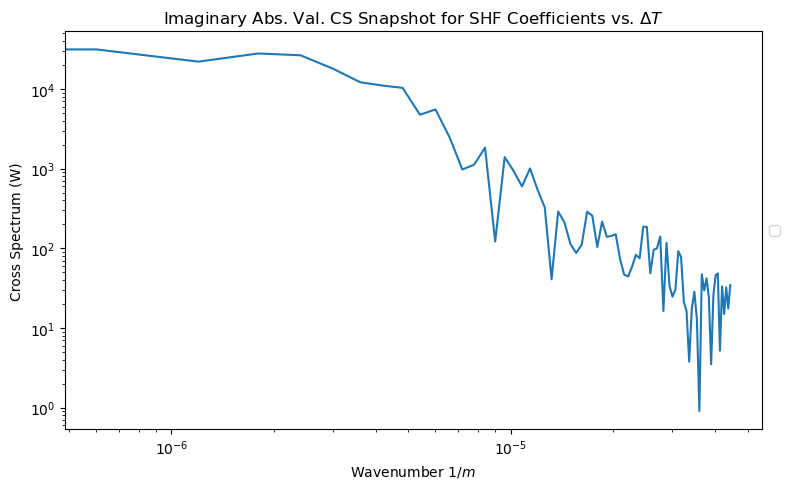

In [18]:
plt.figure(figsize=(8,5))

# Select region, compute variables for co-spectrum
eps = 1e-6
T_diff = ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).surface_temp - ds_HR.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)).t_ref
C = ds_QLQH.qh.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-55, -40)) / (T_diff + 1e-6) # prevent division by 0

# Select time, re-chunk
T_diff_t = T_diff.isel(time=0).chunk({"xt_ocean": -1, "yt_ocean": -1})
C_t = C.isel(time=0).chunk({"xt_ocean": -1, "yt_ocean": -1})

# Degree to m conversion
T_diff_t = T_diff_t.assign_coords(xt_ocean=T_diff_t.xt_ocean*111000)
C_t = C_t.assign_coords(xt_ocean=C_t.xt_ocean*111000)

# Compute cross-spectrum
cross_spec_t = xrft.cross_spectrum(
    T_diff_t,
    C_t,
    dim='xt_ocean',
    window="hann",
    detrend="linear"
).mean(dim='yt_ocean')

# Plot co-spectrum
plt.plot(
    cross_spec_t["freq_xt_ocean"],
    np.abs(cross_spec_t.real)
)

plt.xlabel(r"Wavenumber $1/m$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Cross Spectrum (W)")
plt.title(r"Imaginary Abs. Val. CS Snapshot for SHF Coefficients vs. $\Delta T$")

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1
)
plt.tight_layout()
plt.show()